In [2]:
import pandas as pd
import numpy as np

In [257]:
df = pd.read_csv("/Users/tobifadeyi/Documents/Thesis code/Raw Data/FTSE Combined with scores/combined_all_with_scores.csv")

In [ ]:
missing_100 = df.columns[df.isnull().mean() == 1.0]
print(f"Number of columns with 100% missingness: {len(missing_100)}")
missing_100

Number of columns with 100% missingness: 87


Index(['Fleet Fuel Consumption_x', 'Lobbying Controversies',
       'Lobbying Contribution Amount', 'Recent Public Health Controversies',
       'Recent Critical Countries Controversies',
       'Military Weapons or Personnel Revenue', 'Firearms Producer Revenue',
       'Firearms Retailer Revenue', 'Alcohol Retailer Revenue',
       'Tobacco Retailer Revenue',
       'Military Weapons or Personnel Revenue Percent',
       'Firearms Producer Revenue Percent', 'Gambling Retailer Revenue',
       'Firearms Retailer Revenue Percent',
       'Thermal Coal-fired Power Generation Revenue',
       'Alcohol Retailer Revenue Percent', 'Nuclear Power Generation Revenue',
       'Tobacco Retailer Revenue Percent', 'Gambling Retailer Revenue Percent',
       'Oil Sands Producer Revenue',
       'Thermal Coal-fired Power Generation Revenue Percent',
       'Nuclear Power Generation Revenue Percent',
       'Arctic Oil Producer Revenue', 'Oil Sands Producer Revenue Percent',
       'Arctic Oil Produ

In [258]:
df = df.drop(columns=missing_100, errors='ignore')

In [259]:
gov_path = "/Users/tobifadeyi/Documents/Thesis code/Raw Data/FTSE Combined Data sets/extracted_governance_full.csv"
soc_path = "/Users/tobifadeyi/Documents/Thesis code/Raw Data/FTSE Combined Data sets/extracted_social_full.csv"
env_path = "/Users/tobifadeyi/Documents/Thesis code/Raw Data/FTSE Combined Data sets/extracted_environment_full.csv"


In [261]:
governance = pd.read_csv(gov_path)
social = pd.read_csv(soc_path)
environment = pd.read_csv(env_path)

gov_cols = list(governance.columns)
soc_cols = list(social.columns)
env_cols = list(environment.columns)

# Combine all columns (remove duplicates)
all_cols = list(dict.fromkeys(gov_cols + soc_cols + env_cols))

# Select these columns from df (if they exist)
cols_in_df = [col for col in all_cols if col in df.columns]
merged = df[cols_in_df]


In [262]:
# Split the tab-separated string into a list of column names
cols_to_drop = [
	'ESG Score Grade_x', 'ESG Combined Score Grade_x', 'ESG Score_x', 'ESG Combined Score_x', 'ESG Controversies Score_x',
	'Social Pillar Score Grade_x', 'Governance Pillar Score Grade_x', 'Environmental Pillar Score Grade_x',
	'Social Pillar Score_x', 'Governance Pillar Score_x', 'Environmental Pillar Score_x',
	'Resource Use Score Grade_x', 'Emissions Score Grade_x', 'Environmental Innovation Score Grade_x',
	'Workforce Score Grade_x', 'Human Rights Score Grade_x', 'Community Score Grade_x',
	'Product Responsibility Score Grade_x', 'Management Score Grade_x', 'Shareholders Score Grade_x',
	'CSR Strategy Score Grade_x', 'Resource Use Score_x', 'Emissions Score_x', 'Environmental Innovation Score_x',
	'Workforce Score_x', 'Human Rights Score_x', 'Community Score_x', 'Product Responsibility Score_x',
	'Management Score_x', 'Shareholders Score_x', 'CSR Strategy Score_x', 'Instrument',
]
merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')

/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/1482731155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.drop(columns=cols_to_drop, inplace=True, errors='ignore')


In [263]:
merged.drop_duplicates(inplace=True)

/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/3747040622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.drop_duplicates(inplace=True)


In [264]:
merged = merged.drop('Instrument', axis=1, errors='ignore')

In [265]:
merged_table = merged.copy()

In [272]:
def robust_bool_to_numeric(series):
    """
    Converts a pandas Series with boolean-like values to 1/0, leaves others unchanged.
    """
    mapping = {
        'true': 1, '1': 1, 'yes': 1, True: 1,
        'false': 0, '0': 0, 'no': 0, False: 0
        , 'No': 0, 'NO': 0, 'Yes': 1, 'YES': 1
    }
    return series.apply(lambda x: mapping.get(str(x).strip().lower(), x) if pd.notnull(x) else x)

for col in merged_table.columns:
    unique = set(str(x).strip().lower() for x in merged_table[col].dropna().unique())
    # Only convert if column contains *only* these values (and NaN)
    if unique <= {'true','false','1','0','yes','no','No','NO','Yes','YES', True, False}:
        merged_table[col] = robust_bool_to_numeric(merged_table[col])



In [268]:
percent_map = {
    '100%': 1.0,
    '>50% to 100%': 0.75,
    '>20% to 50%': 0.35,
    '>10% to 20%': 0.15,
    '0 to 10%': 0.05,
    '>10% to 20%': 0.15,
    '>20% to 50%': 0.35,
    '>50% to 100%': 0.75,
    # add other mappings as needed
}

for col in merged_table.columns:
    if set(str(x).strip() for x in merged_table[col].dropna().unique()).issubset(percent_map.keys()):
        merged_table[col] = merged_table[col].map(percent_map)


In [273]:
merged_table.select_dtypes(include='object').columns.tolist()

['CSR Sustainability External Auditor Name',
 'ESG Period Last Update Date',
 'Critical Country 1',
 'Critical Country 2',
 'Critical Country 3',
 'Critical Country 4',
 'Critical Country 5',
 'CO2 Estimation Method',
 'ISO 14000 or EMS']

In [277]:
possible_categorical = merged_table.select_dtypes(include='object').nunique()

In [283]:
cat_cols = possible_categorical[possible_categorical <= 100].index

In [284]:
for col in cat_cols:
	print(f"{col}: {merged_table[col].unique()}")

Critical Country 1: [nan 'CU' 'SD']
Critical Country 2: [nan 'IR']
Critical Country 3: [nan 'MM']
Critical Country 4: [nan 'SD']
Critical Country 5: [nan 'IR']
CO2 Estimation Method: [nan 'Median' 'Reported']
ISO 14000 or EMS: [nan 'No' 'ISO 14000' 'Both' 'EMS']


In [275]:
merged_table.loc[:, merged.dtypes == 'object']

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  CO2 Estimation Method  Particulate Matter Emissions Reduction  \
0    ...                    NaN                                     NaN   
1    ...                 Median                                     0.0   
2    ...                 Median                                     0.0   
3    ...               Reported                                     0.0   
4    ...               Reported                                     0.0   

In [229]:
merged_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Self-Reported Environmental Fines To Revenues in million  \
0    ...                                                NaN          
1    ...                                                NaN          
2    ...                                                NaN          
3    ...                                                NaN          
4    ...                                                NaN          
..   ...                     

In [164]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')


In [278]:
# Select columns with 10 or fewer unique values (likely categorical)
cat_cols = possible_categorical[possible_categorical <= 100].index
merged_table.loc[:, cat_cols]

CSR Sustainability External Auditor Name ESG Period Last Update Date  \
0                                        NaN                         NaN   
1                                        NaN                  2025-05-30   
2                                        NaN                  2025-05-30   
3                                        NaN                  2025-06-20   
4                                        NaN                  2025-06-20   
..                                       ...                         ...   
514                    Corporate Citizenship                  2025-02-28   
515                    Corporate Citizenship                  2025-06-06   
516                    Corporate Citizenship                  2025-06-20   
517                         RSM UK Audit LLP                  2025-07-25   
518                         RSM UK Audit LLP                  2025-07-25   

    Critical Country 1 Critical Country 2 Critical Country 3  \
0                  NaN                NaN                NaN   
1                  NaN                NaN                NaN   
2                  NaN                NaN                NaN   
3                  NaN                NaN                NaN   
4                  NaN                NaN                NaN   
..                 ...                ...                ...   
514                NaN                NaN                NaN   
515                NaN                NaN                NaN   
516                NaN                NaN                NaN   
517                NaN                NaN                NaN   
518                NaN                NaN                NaN   

    Critical Country 4 Critical Country 5 CO2 Estimation Method  \
0                  NaN                NaN                   NaN   
1                  NaN                NaN                Median   
2                  NaN                NaN                Median   
3                  NaN                NaN              Reported   
4                  NaN                NaN              Reported   
..                 ...                ...                   ...   
514                NaN                NaN              Reported   
515                NaN                NaN              Reported   
516                NaN                NaN              Reported   
517                NaN                NaN              Reported   
518                NaN                NaN              Reported   

    ISO 14000 or EMS  
0                NaN  
1                 No  
2                 No  
3                 No  
4                 No  
..               ...  
514               No  
515               No  
516               No  
517               No  
518               No  

[479 rows x 9 columns]

In [279]:
merged.drop(columns=['ESG Period Last Update Date'], inplace=True, errors='ignore')
merged_table.drop(columns=['ESG Period Last Update Date'], inplace=True, errors='ignore')
merged_table.drop(columns=['CSR Sustainability External Auditor Name'], inplace=True, errors='ignore')
merged.drop(columns=['CSR Sustainability External Auditor Name'], inplace=True, errors='ignore')  

In [281]:
possible_categorical = merged_table.select_dtypes(include='object').nunique()
cat_cols = possible_categorical[possible_categorical <= 100].index
merged_table.loc[:, cat_cols]

Critical Country 1 Critical Country 2 Critical Country 3  \
0                  NaN                NaN                NaN   
1                  NaN                NaN                NaN   
2                  NaN                NaN                NaN   
3                  NaN                NaN                NaN   
4                  NaN                NaN                NaN   
..                 ...                ...                ...   
514                NaN                NaN                NaN   
515                NaN                NaN                NaN   
516                NaN                NaN                NaN   
517                NaN                NaN                NaN   
518                NaN                NaN                NaN   

    Critical Country 4 Critical Country 5 CO2 Estimation Method  \
0                  NaN                NaN                   NaN   
1                  NaN                NaN                Median   
2                  NaN                NaN                Median   
3                  NaN                NaN              Reported   
4                  NaN                NaN              Reported   
..                 ...                ...                   ...   
514                NaN                NaN              Reported   
515                NaN                NaN              Reported   
516                NaN                NaN              Reported   
517                NaN                NaN              Reported   
518                NaN                NaN              Reported   

    ISO 14000 or EMS  
0                NaN  
1                 No  
2                 No  
3                 No  
4                 No  
..               ...  
514               No  
515               No  
516               No  
517               No  
518               No  

[479 rows x 7 columns]

In [285]:
merged_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Self-Reported Environmental Fines To Revenues in million  \
0    ...                                                NaN          
1    ...                                                NaN          
2    ...                                                NaN          
3    ...                                                NaN          
4    ...                                                NaN          
..   ...                     

In [67]:
feature_cols = [col for col in df.columns if col not in exclude_cols]

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [286]:
missing_100_merged = merged.columns[merged.isnull().mean() == 1.0]
print(f"Number of columns with 100% missingness in merged: {len(missing_100_merged)}")
missing_100_merged

Number of columns with 100% missingness in merged: 0


Index([], dtype='object')

In [319]:
cleaned_merged = merged_table.copy()

In [320]:
# 1. Remove features with >80% missing values
missing_threshold = 0.8
keep_cols = [col for col in cleaned_merged.columns if cleaned_merged[col].isnull().mean() < missing_threshold]
filtered_table = cleaned_merged[keep_cols]

print(f"Columns removed due to missingness: {set(cleaned_merged.columns) - set(filtered_table.columns)}")

# 2. Remove features with low variance (all values the same, or only one unique non-null value)
low_variance_cols = [col for col in filtered_table.columns if filtered_table[col].nunique(dropna=True) <= 1]
filtered_table = filtered_table.drop(columns=low_variance_cols)

print(f"Columns removed due to low variance: {low_variance_cols}")

# Now filtered_table contains only features with reasonable data and some variation.


Columns removed due to missingness: {'Recent Tax Fraud Controversies', 'NOx Emissions', 'White - Ethnic Minorities Board Percentage_x', 'Controversies Customer Health & Safety', 'Recent Mgt Compensation Controversies_y', 'Customer Satisfaction', 'Oil and Gas Producer Revenue Percent', 'Tobacco Producer Revenue', 'Water Stressed Sites', 'Military Weapons or Personnel Ownership Percent', 'Targets Board Diversity Percent', 'SOx Emissions', 'Training Costs Total', 'Training Costs Per Employee', 'NOx Emissions To EVIC USD in million', 'Recent Wages Working Condition Controversies', 'Renewable Energy Supply', 'Oil and Gas Producer Ownership Percent', 'Ethnic Minorities Salary Gap', 'Targets Board Diversity - Target Year', 'Contractor Lost Working Days', 'Flaring Gases To EVIC USD in million', 'Self-Reported Environmental Fines To Revenues in million', 'Alcohol Revenues', 'Lost Days To Total Days', 'FDA Warning Letters', 'Emission Controversies Count', 'VOC Emissions To Revenues USD in millio

In [ ]:
ESG Score	ESG Combined Score	ESG Controversies Score	Social Pillar Score Grade	Governance Pillar Score Grade	Environmental Pillar Score Grade	Social Pillar Score	Governance Pillar Score	Environmental Pillar Score	Resource Use Score Grade	Emissions Score Grade	Environmental Innovation Score Grade	Workforce Score Grade	Human Rights Score Grade	Community Score Grade	Product Responsibility Score Grade	Management Score Grade	Shareholders Score Grade	CSR Strategy Score Grade	Resource Use Score	Emissions Score	Environmental Innovation Score	Workforce Score	Human Rights Score	Community Score	Product Responsibility Score	Management Score	Shareholders Score	CSR Strategy Score

In [321]:
# Reindex merged_table to match df if needed
cleaned_merged = merged_table.reindex(df.index)
for col in ['Social Pillar Score', 'Governance Pillar Score', 'Environmental Pillar Score']:
    if col in df.columns:
        merged_table[col] = df[col]


In [322]:
keep_clean = cleaned_merged.copy()

In [323]:
cleaned_merged = pd.get_dummies(cleaned_merged, columns=cat_cols, dummy_na=True, drop_first=False)

In [324]:
cleaned_merged

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Critical Country 5_IR  Critical Country 5_nan  \
0    ...                  False                    True   
1    ...                  False                    True   
2    ...                  False                    True   
3    ...                  False                    True   
4    ...                  False                    True   
..   ...                    ...                     ...   
514  ...                  False     

In [ ]:
bool_cols = cleaned_merged.select_dtypes(include=['bool']).columns
cleaned_merged[bool_cols] = cleaned_merged[bool_cols].astype(int)


/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/1595513946.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


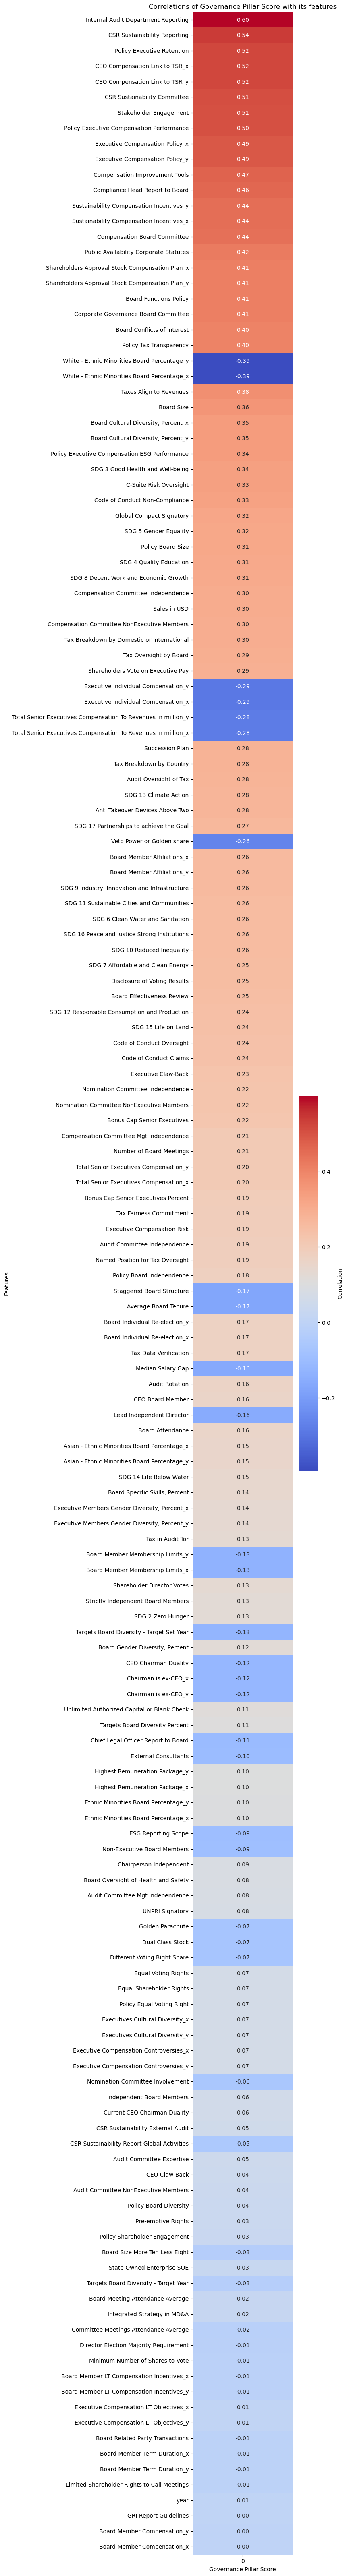


Top 10 features for Governance Pillar Score:
Internal Audit Department Reporting          0.599177
CSR Sustainability Reporting                 0.540179
Policy Executive Retention                   0.519847
CEO Compensation Link to TSR_x               0.517984
CEO Compensation Link to TSR_y               0.517984
CSR Sustainability Committee                 0.506923
Stakeholder Engagement                       0.505036
Policy Executive Compensation Performance    0.504792
Executive Compensation Policy_x              0.489000
Executive Compensation Policy_y              0.489000
dtype: float64


/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/1595513946.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


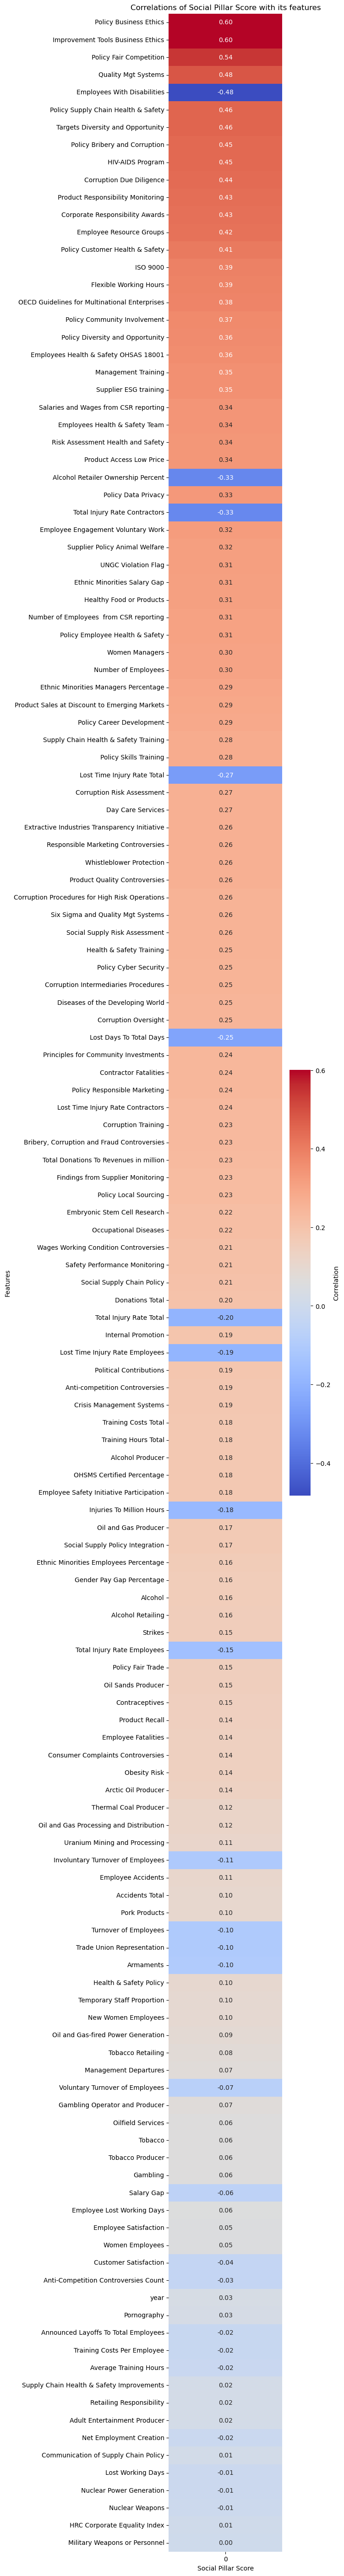


Top 10 features for Social Pillar Score:
Policy Business Ethics                 0.601216
Improvement Tools Business Ethics      0.600398
Policy Fair Competition                0.544255
Quality Mgt Systems                    0.484929
Employees With Disabilities           -0.482993
Policy Supply Chain Health & Safety    0.456126
Targets Diversity and Opportunity      0.455990
Policy Bribery and Corruption          0.448578
HIV-AIDS Program                       0.448418
Corruption Due Diligence               0.440632
dtype: float64


/var/folders/fl/lv0hc01x58s_68_8g3k5dngc0000gn/T/ipykernel_6891/1595513946.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


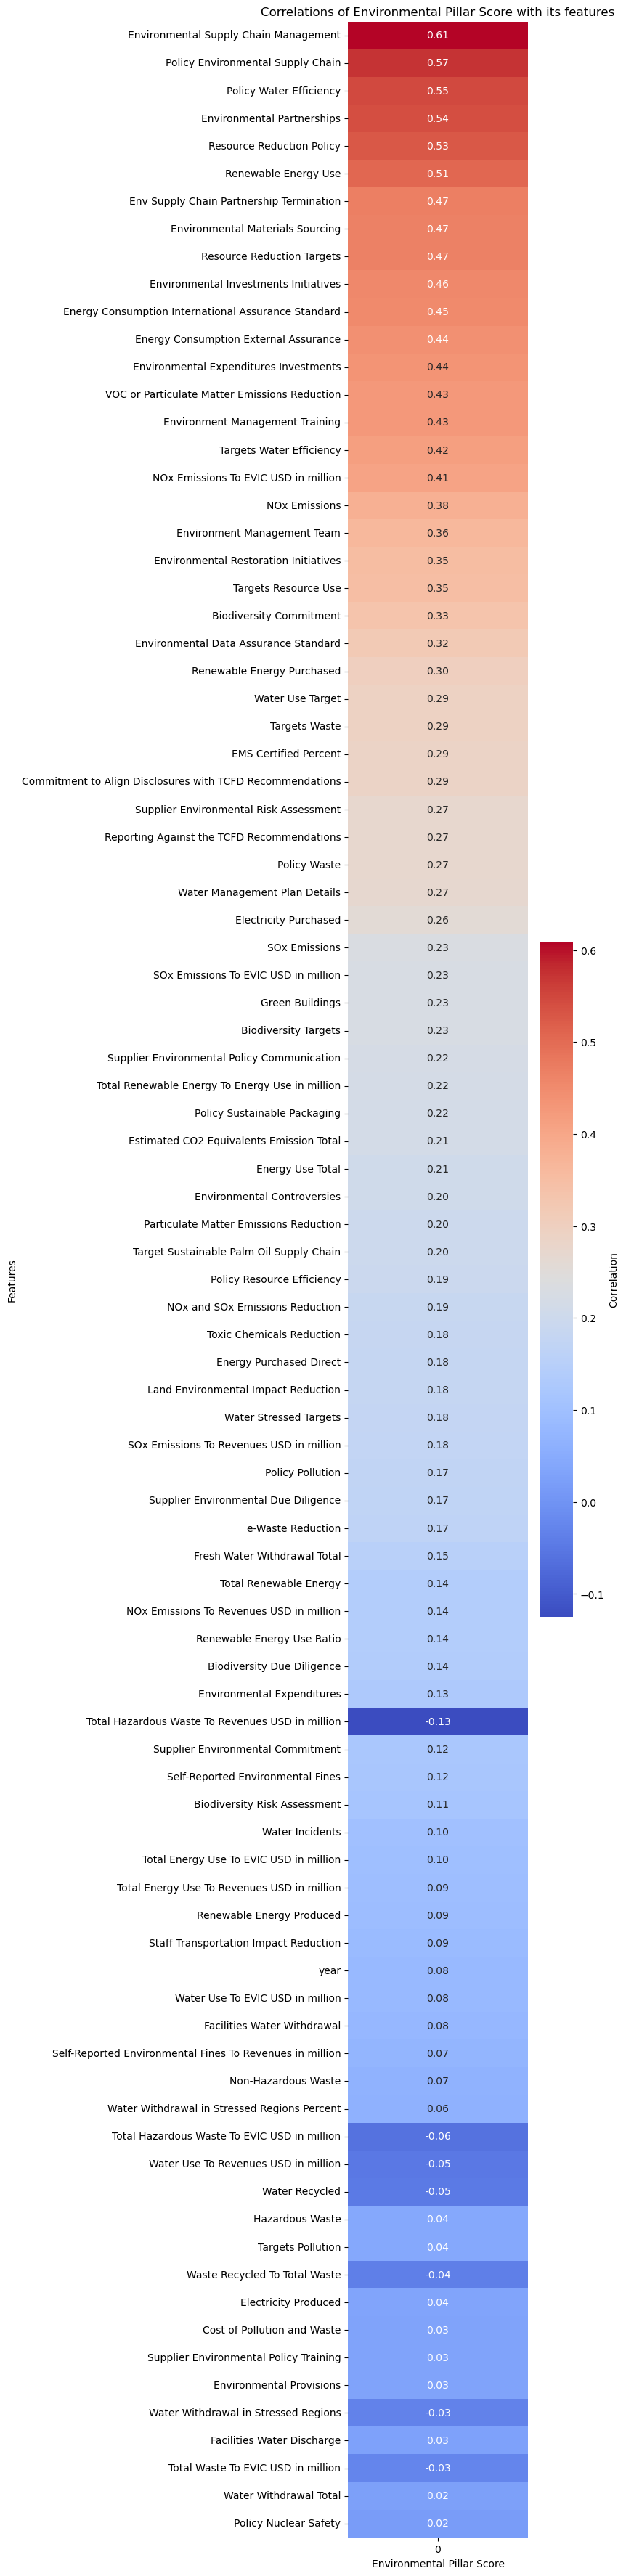


Top 10 features for Environmental Pillar Score:
Environmental Supply Chain Management       0.609033
Policy Environmental Supply Chain           0.573513
Policy Water Efficiency                     0.546580
Environmental Partnerships                  0.542712
Resource Reduction Policy                   0.527058
Renewable Energy Use                        0.507124
Env Supply Chain Partnership Termination    0.468990
Environmental Materials Sourcing            0.467339
Resource Reduction Targets                  0.467151
Environmental Investments Initiatives       0.456055
dtype: float64


In [ ]:
# ---- 1. Remove features with >90% missing values ----
missing_threshold = 0.9
keep_cols = [col for col in cleaned_merged.columns if cleaned_merged[col].isnull().mean() < missing_threshold]
filtered_table = cleaned_merged[keep_cols]

# ---- 2. Remove low-variance features ----
low_variance_cols = [col for col in filtered_table.columns if filtered_table[col].nunique(dropna=True) <= 1]
filtered_table = filtered_table.drop(columns=low_variance_cols)

# ---- 3. Prepare pillar-specific feature lists ----
gov_features = [col for col in governance if col in filtered_table.columns]
soc_features = [col for col in social if col in filtered_table.columns]
env_features = [col for col in environment if col in filtered_table.columns]

target_cols = {
    'Governance Pillar Score': gov_features,
    'Social Pillar Score': soc_features,
    'Environmental Pillar Score': env_features
}

corr_results = {}

for target, feats in target_cols.items():
    corr_dict = {}
    for feat in feats:
        # Only use numeric features
        if pd.api.types.is_numeric_dtype(filtered_table[feat]):
            valid = filtered_table[[feat, target]].dropna()
            if len(valid) > 2:
                corr_dict[feat] = valid[feat].corr(valid[target])
            else:
                corr_dict[feat] = np.nan
    corr_results[target] = pd.Series(corr_dict)

# ---- 4. Plot heatmap for each pillar ----
for target, corr_series in corr_results.items():
    sorted_corr = corr_series.dropna().sort_values(key=abs, ascending=False)
    plt.figure(figsize=(4, max(6, len(sorted_corr) // 2)))
    sns.heatmap(
        sorted_corr.values.reshape(-1, 1), 
        annot=True, fmt=".2f",
        yticklabels=sorted_corr.index, cmap='coolwarm',
        cbar_kws={'label': 'Correlation'}
    )
    plt.title(f"Correlations of {target} with its features")
    plt.ylabel('Features')
    plt.xlabel(target)
    plt.tight_layout()
    plt.show()
    # Print top features
    print(f"\nTop 10 features for {target}:")
    print(sorted_corr.head(10))


In [329]:
filtered_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Critical Country 5_IR  Critical Country 5_nan  \
0    ...                      0                       1   
1    ...                      0                       1   
2    ...                      0                       1   
3    ...                      0                       1   
4    ...                      0                       1   
..   ...                    ...                     ...   
514  ...                      0     

In [331]:
numeric_cols = filtered_table.select_dtypes(include=[np.number]).columns

# Optionally, drop target columns if you only want feature-feature correlations
features_only = [col for col in numeric_cols if col not in target_cols.keys()]
# corr_matrix = imputed_table[features_only].corr()
# Or keep targets in the matrix:
corr_matrix = filtered_table[numeric_cols].corr()

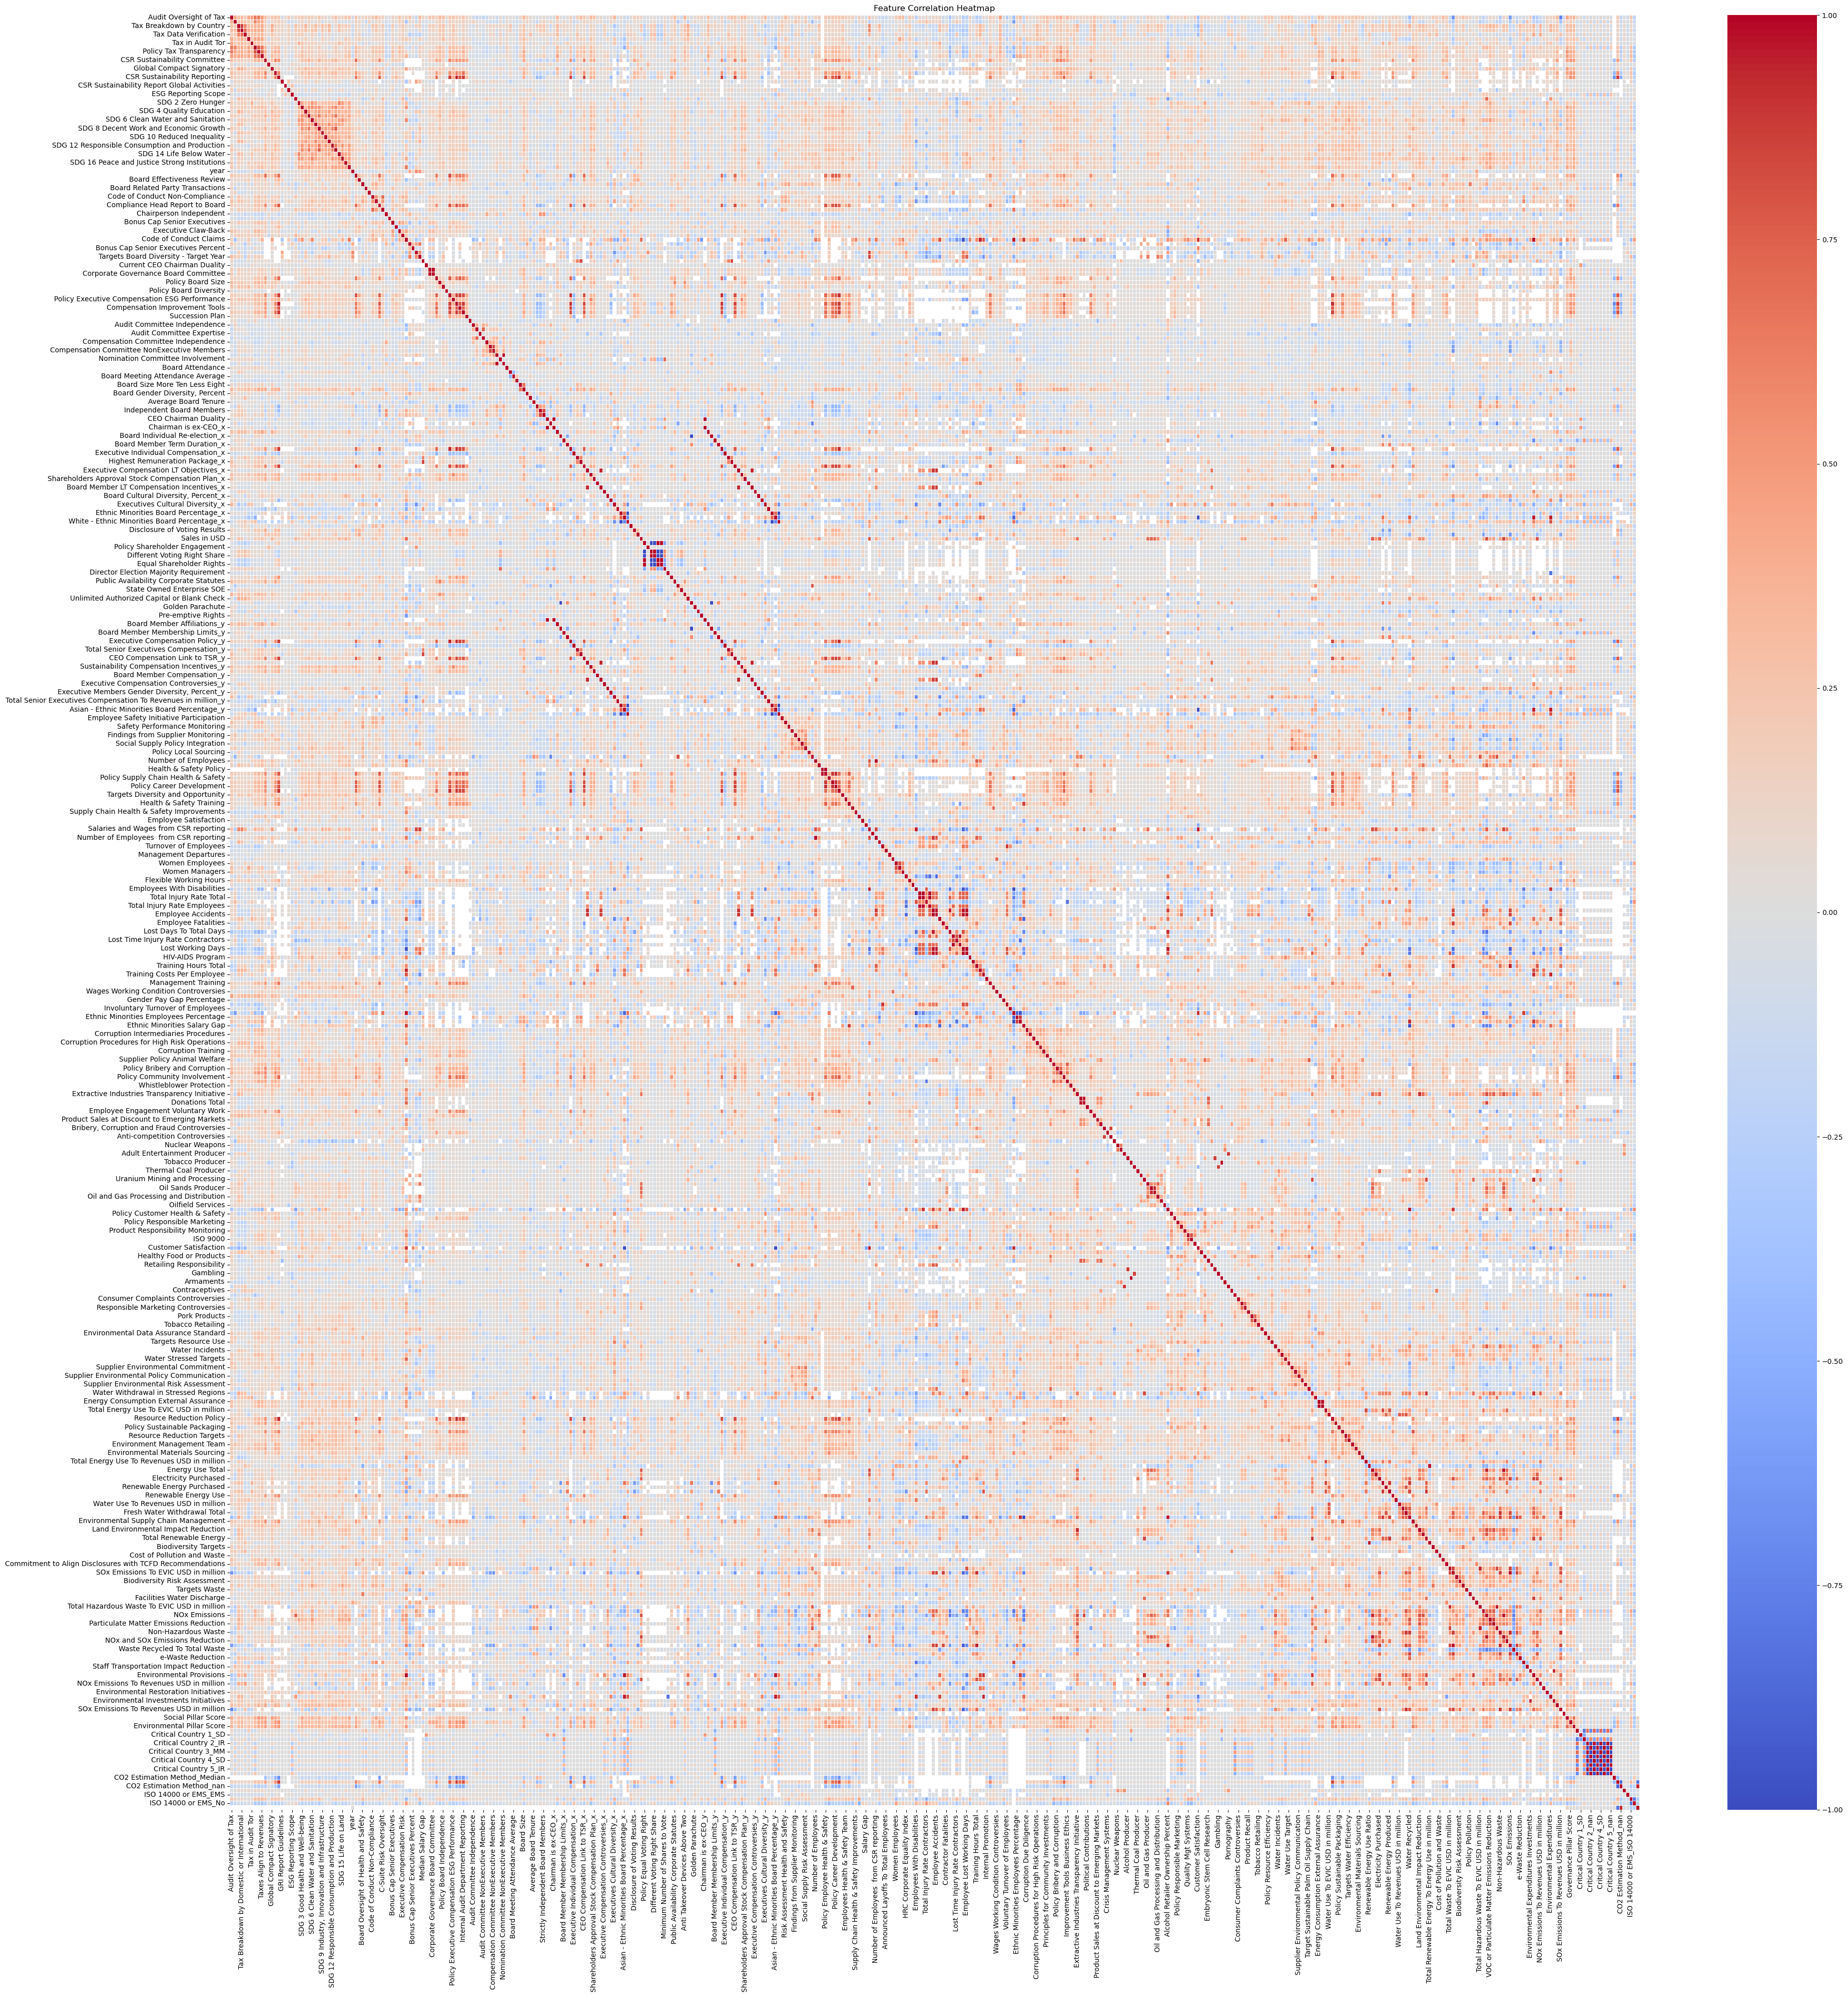

In [332]:
plt.figure(figsize=(min(40, len(numeric_cols)//2), min(40, len(numeric_cols)//2)))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


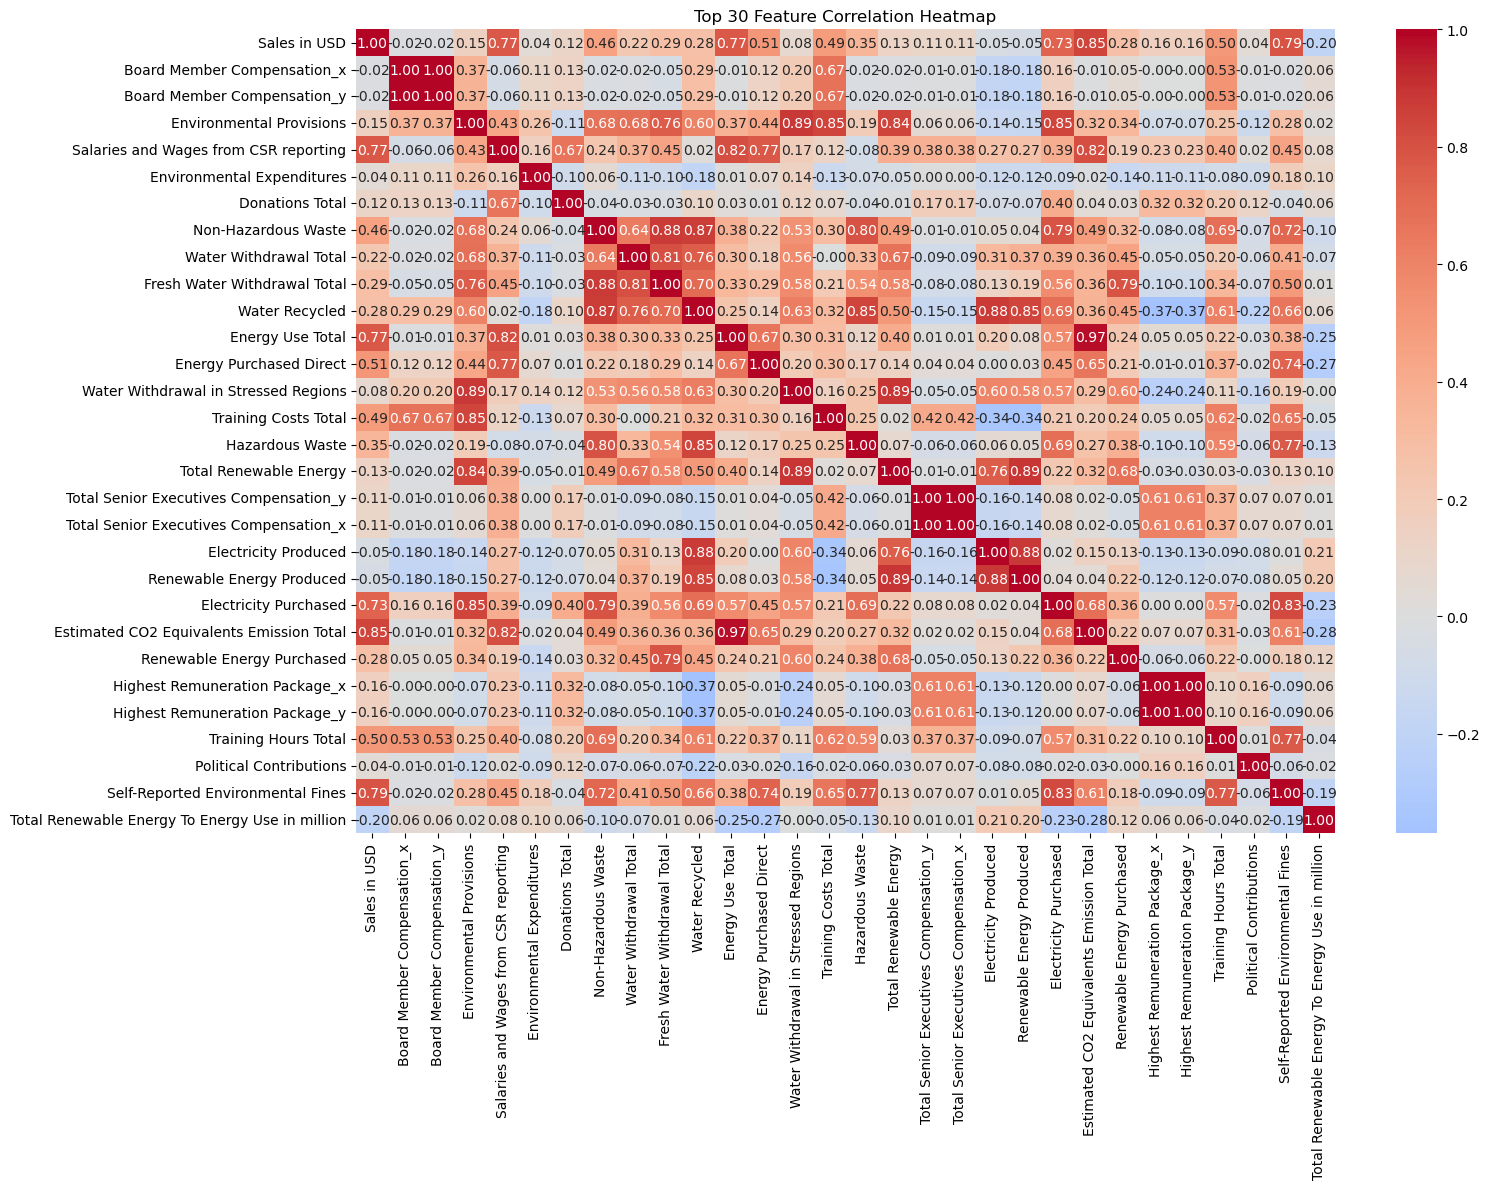

In [333]:
# Example: Plot only top 30 features by variance
top_n = 30
top_features = filtered_table[numeric_cols].var().sort_values(ascending=False).head(top_n).index
corr_matrix_top = filtered_table[top_features].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix_top, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Top 30 Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [334]:
# Calculate the full correlation matrix
corr_matrix = filtered_table.select_dtypes(include=[np.number]).corr().abs()

# Set self-correlations to zero so we don't accidentally drop a feature for being "identical to itself"
np.fill_diagonal(corr_matrix.values, 0)

# Find columns with any correlation > 0.95
to_drop = set()
for col in corr_matrix.columns:
    # If this column is highly correlated with any later column, mark it for dropping
    high_corr = corr_matrix[col][corr_matrix[col] > 0.95].index
    to_drop.update(high_corr)

print(f"Dropping {len(to_drop)} highly correlated features:\n", to_drop)

reduced_table = filtered_table.drop(columns=to_drop)


Dropping 104 highly correlated features:
 {'NOx Emissions', 'White - Ethnic Minorities Board Percentage_x', 'Customer Satisfaction', 'Corporate Governance Board Committee', 'Executive Members Gender Diversity, Percent_y', 'Energy Use Total', 'SOx Emissions', 'Energy Consumption International Assurance Standard', 'Ethnic Minorities Salary Gap', 'Board Member Term Duration_y', 'Total Senior Executives Compensation_x', 'Lost Days To Total Days', 'Executive Compensation Policy_y', 'Different Voting Right Share', 'SOx Emissions To EVIC USD in million', 'Total Senior Executives Compensation_y', 'Donations Total', 'Lost Time Injury Rate Total', 'Renewable Energy Use Ratio', 'Accidents Total', 'Critical Country 5_IR', 'Critical Country 2_nan', 'Dual Class Stock', 'Water Recycled', 'Energy Consumption External Assurance', 'Equal Shareholder Rights', 'Employee Lost Working Days', 'Chairman is ex-CEO_x', 'Board Member Affiliations_y', 'Critical Country 3_MM', 'Total Injury Rate Total', 'Executive

In [335]:
reduced_table

Audit Oversight of Tax  Named Position for Tax Oversight  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       0.0                               0.0   
4                       0.0                               0.0   
..                      ...                               ...   
514                     NaN                               NaN   
515                     NaN                               NaN   
516                     0.0                               0.0   
517                     0.0                               0.0   
518                     0.0                               0.0   

     Tax Breakdown by Country  Tax Breakdown by Domestic or International  \
0                         NaN                                         NaN   
1                         NaN                                         NaN   
2                         NaN                                         NaN   
3                         0.0                                         0.0   
4                         0.0                                         0.0   
..                        ...                                         ...   
514                       NaN                                         NaN   
515                       NaN                                         NaN   
516                       0.0                                         0.0   
517                       0.0                                         0.0   
518                       0.0                                         0.0   

     Tax Data Verification  Tax Fairness Commitment  Tax in Audit Tor  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   
..                     ...                      ...               ...   
514                    NaN                      NaN               NaN   
515                    NaN                      NaN               NaN   
516                    0.0                      0.0               0.0   
517                    0.0                      0.0               0.0   
518                    0.0                      0.0               0.0   

     Tax Oversight by Board  Policy Tax Transparency  Taxes Align to Revenues  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       0.0                      0.0                      0.0   
4                       0.0                      0.0                      0.0   
..                      ...                      ...                      ...   
514                     NaN                      NaN                      NaN   
515                     NaN                      NaN                      NaN   
516                     0.0                      0.0                      0.0   
517                     0.0                      0.0                      0.0   
518                     0.0                      0.0                      0.0   

     ...  Critical Country 1_SD  Critical Country 1_nan  \
0    ...                      0                       1   
1    ...                      0                       1   
2    ...                      0                       1   
3    ...                      0                       1   
4    ...                      0                       1   
..   ...                    ...                     ...   
514  ...                      0     